# Ground Truth

## Introduction
In this Jupyter Notebook we determine the best temporal reducers for leaf type mixture prediction using Sentinel 2 satellite imagery. The experiment involves processing the satellite imagery using the Google Earth Engine (GEE). Please refer to the README file in this repository for a tutorial on how to set up GEE.

# Preprocessing
The ground truth label is computed from the [25 ha Traunstein Forest Dynamics Plot](https://forestgeo.si.edu/sites/europe/traunstein). You can request the dataset [here](http://ctfs.si.edu/datarequest/index.php/request/form/31). Alternatively you can use the processed GeoTIFF raster "data/processed/y.tif" for the leaf type mixture label. The raster "data/processed/y_area.tif" contains the base area per leaf type.

This notebook loads the dataset, analyzes it and creates two rasters from it. One raster contains the conifer proportion, the other raster contains the absolute base area per pixel per leaf type.

In [1]:
# Load the data and convert it to a GeoDataFrame
import pandas as pd
import geopandas as gpd

df = pd.read_csv("../data/interim/plot.csv", parse_dates=["date"])

data = df.drop(["longitude", "latitude"], axis=1)
geometry = gpd.points_from_xy(df["longitude"], df["latitude"])
gdf = gpd.GeoDataFrame(data, crs="EPSG:4326", geometry=geometry)

gdf = gdf.to_crs("EPSG:32633")

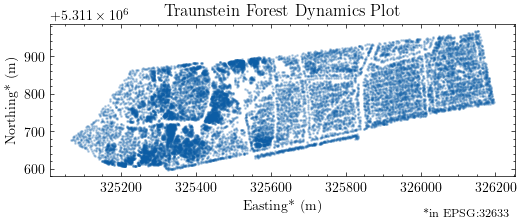

In [2]:
# Plot the data on stem level
import matplotlib.pyplot as plt
import scienceplots

plt.style.use("science")

ax = gdf.plot(markersize=1, figsize=(6, 2), alpha=0.25)
ax.set_title("Traunstein Forest Dynamics Plot")
ax.set_xlabel("Easting* (m)")
ax.set_ylabel("Northing* (m)")
ax.annotate("*in EPSG:32633", (ax.get_position().x1-0.05, 0), xycoords="figure fraction", va="bottom", ha="right", fontsize="small")
fig = ax.get_figure()
plt.show()

First sample: 2015-03-11
Last sample: 2016-04-13


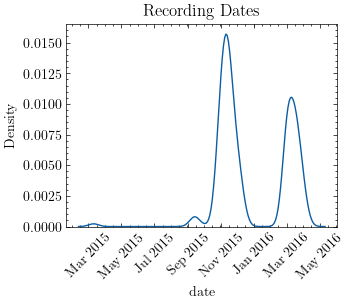

In [3]:
# Plot the distribution of the recording dates
import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime

print(f"First sample: {gdf['date'].min().strftime('%Y-%m-%d')}")
print(f"Last sample: {gdf['date'].max().strftime('%Y-%m-%d')}")

ax = sns.kdeplot(gdf["date"], label="Recording Dates KDE")
ax.set_title("Recording Dates")
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))

plt.show()

In [4]:
# Convert the data to two rasters
from ltm.data import compute_label
from pathlib import Path

y_path = "../data/processed/y.tif"
y_area_path = "../data/processed/y_area.tif"

if not Path(y_path).exists():
    compute_label(y_path=y_path, plot=df)

if not Path(y_area_path).exists():
    compute_label(y_path=y_area_path, plot=df, area_as_y=True)

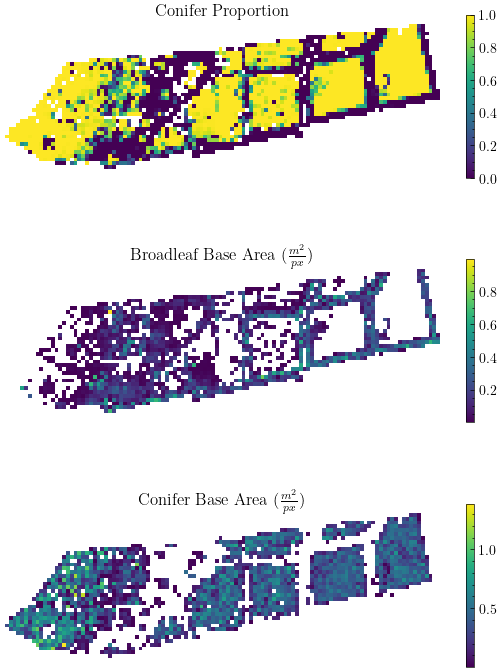

In [5]:
# Plot the two rasters, plot the base area separately per leaf type
import rasterio
import numpy as np

fig, axes = plt.subplots(3, 1, figsize=(7, 9))

with rasterio.open("../data/processed/y.tif") as src:
    # Plot the broadleaf content
    y = src.read(1)

    img = axes[0].imshow(y, cmap="viridis", interpolation="nearest")
    axes[0].set_title("Conifer Proportion")
    axes[0].axis("off")

    fig.colorbar(img, shrink=0.8)

with rasterio.open("../data/processed/y_area.tif") as src:
    # Plot the broadleaf area
    broadleaf_area = src.read(1)
    broadleaf_area[broadleaf_area == 0] = np.nan

    img = axes[1].imshow(broadleaf_area, cmap="viridis", interpolation="nearest")
    axes[1].set_title(r"Broadleaf Base Area ($\frac{m^2}{px}$)")
    axes[1].axis("off")

    fig.colorbar(img, shrink=0.8)

    # Plot the conifer area
    conifer_area = src.read(2)
    conifer_area[conifer_area == 0] = np.nan

    img = axes[2].imshow(conifer_area, cmap="viridis", interpolation="nearest")
    axes[2].set_title(r"Conifer Base Area ($\frac{m^2}{px}$)")
    axes[2].axis("off")

    fig.colorbar(img, shrink=0.8)

plt.show()